In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import GCRCatalogs
from GCRCatalogs.helpers.tract_catalogs import tract_filter, sample_filter
from GCRCatalogs import GCRQuery
import numpy as np
from matplotlib.patches import Rectangle
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.io import ascii
import sys
import os
import shutil
import pickle
import healpy as hp
import h5py
import pandas as pd

###clevar
import clevar
from clevar import ClCatalog
from clevar.match import ProximityMatch
from clevar.match_metrics import scaling
from clevar.match_metrics import recovery
from clevar.match_metrics import distances
from clevar.match import get_matched_pairs
from clevar.match import output_matched_catalog

In [2]:
#print(cat.list_all_quantities())
#print(amico_data.colnames)

In [3]:
cat = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_small")
cosmodc2_data = cat.get_quantities(['halo_id', 'ra', 'dec', 'redshift', 'halo_mass'], filters=['halo_mass > 1e13', 'is_central'])

inpath = '/sps/lsst/users/tguillem/DESC/desc_april_2022/cluster_challenge/clevar_catalogs/amico/map_detections_refined_noBuffer_all.fits'
amico_data = Table.read(inpath)['ID', 'Xphys', 'Yphys', 'Zphys','LAMBSTAR', 'SN_NO_CLUSTER', 'SN']

In [4]:
display(cosmodc2_data)
display(amico_data)

{'halo_id': array([    400155487,   37900155453,   14700155442, ..., 4947200143121,
        5034100143121, 5190600143121]),
 'halo_mass': array([1.20693136e+13, 1.08875610e+13, 3.35196754e+13, ...,
        1.01222852e+13, 1.17543531e+13, 1.01066673e+13]),
 'dec': array([-40.90712062, -39.80574429, -40.39291947, ..., -39.39533307,
        -38.44647908, -37.98886023]),
 'ra': array([61.86959634, 61.29557256, 62.96121751, ..., 66.43947083,
        66.96447882, 66.25907421]),
 'redshift': array([0.02133399, 0.09395244, 0.1034696 , ..., 2.95665272, 3.00394233,
        2.97568348])}

ID,Xphys,Yphys,Zphys,LAMBSTAR,SN_NO_CLUSTER,SN
int16,float64,float64,float64,float64,float64,float64
3,61.378983,-39.994438,0.78999996,115.96933,46.630722,7.4621258
7,61.758209,-39.59544,0.35999998,27.27791,31.331249,6.8403945
9,62.62199,-40.858124,0.25,33.274879,24.420267,6.2714334
10,62.198517,-39.405045,0.54999995,22.638201,27.017937,5.8959146
11,61.961666,-41.425468,0.63,23.205885,22.496141,5.7495751
12,62.013664,-40.785416,0.74999994,41.223412,28.051762,5.7198601
13,61.476517,-41.169827,0.36999997,16.307556,23.040657,5.7072597
14,61.914318,-40.275494,0.63,25.189159,21.83959,5.6594982
15,62.070724,-39.970333,0.48999998,19.568504,23.899815,5.6358972


In [5]:
cdc = ClCatalog('Cat_cosmoDC2', ra=cosmodc2_data['ra'], dec=cosmodc2_data['dec'], z=cosmodc2_data['redshift'], mass=cosmodc2_data['halo_mass'])
cam = ClCatalog('Cat_amico', ra=amico_data['Xphys'], dec=amico_data['Yphys'], z=amico_data['Zphys'], richness = amico_data['LAMBSTAR'], SN = amico_data['SN'], SN_NO_CLUSTER = amico_data['SN_NO_CLUSTER'])

/sps/lsst/users/namourou/conda_clone_210223/descv1.1/clevar/clevar/catalog.py:267: UserWarning: id column missing, additional one is being created.
  warnings.warn(


In [6]:
# Format for nice display
"""
for c in ('ra', 'dec', 'z'):
    cdc[c].info.format = '.2f'
    cam[c].info.format = '.2f'
display(cdc)
display(cam)
"""

"\nfor c in ('ra', 'dec', 'z'):\n    cdc[c].info.format = '.2f'\n    cam[c].info.format = '.2f'\ndisplay(cdc)\ndisplay(cam)\n"

In [7]:
from clevar.match import ProximityMatch
mt = ProximityMatch()

In [8]:
match_config = {
    'type': 'cross', # options are cross, cat1, cat2
    'which_radius': 'max', # Case of radius to be used, can be: cat1, cat2, min, max
    'preference': 'angular_proximity', # options are more_massive, angular_proximity or redshift_proximity
    'catalog1': {'delta_z':.05,
                'match_radius': '1 mpc'
                },
    'catalog2': {'delta_z':.05,
                'match_radius': '1 mpc'
                }
}
from clevar.cosmology import AstroPyCosmology
cosmo = AstroPyCosmology()

In [9]:
mt.match_from_config(cdc, cam, match_config, cosmo=cosmo)


## ClCatalog 1
## Prep mt_cols
* zmin|zmax from config value
* ang radius from set scale

## ClCatalog 2
## Prep mt_cols
* zmin|zmax from config value
* ang radius from set scale

## Multiple match (catalog 1)
Finding candidates (Cat_cosmoDC2)
* 17,627/61,725 objects matched.

## Multiple match (catalog 2)
Finding candidates (Cat_amico)
* 10,167/11,485 objects matched.

## Finding unique matches of catalog 1
Unique Matches (Cat_cosmoDC2)
* 9,878/61,725 objects matched.

## Finding unique matches of catalog 2
Unique Matches (Cat_amico)
* 9,879/11,485 objects matched.
Cross Matches (Cat_cosmoDC2)
* 9,860/61,725 objects matched.
Cross Matches (Cat_amico)
* 9,860/11,485 objects matched.


In [10]:
outpath = '/pbs/home/n/namourou/test_jupyter/cluster_challenge/notebooks/outfiles_1013/'

In [11]:
cdc.cross_match()
cam.cross_match()
cdc.write(outpath + 'cdc.fits', overwrite=True)
cam.write(outpath + 'cam.fits', overwrite = True)

mt.save_matches(cdc, cam, out_dir=outpath, overwrite=True)

In [12]:
mt.load_matches(cdc, cam, out_dir=outpath)
display(cdc)
display(cam)

Cat_cosmoDC2
    * ClEvar used in matching: 0.13.8
 * Total objects:    61,725
 * multiple (self):  17,627
 * multiple (other): 17,627
 * unique (self):    9,878
 * unique (other):   9,879
 * cross:            9,860

Cat_amico
    * ClEvar used in matching: 0.13.8
 * Total objects:    11,485
 * multiple (self):  10,167
 * multiple (other): 10,167
 * unique (self):    9,879
 * unique (other):   9,878
 * cross:            9,860


In [13]:
mt1, mt2 = get_matched_pairs(cdc, cam, 'cross')

In [14]:
mt1

Text(0, 0.5, 'dec')

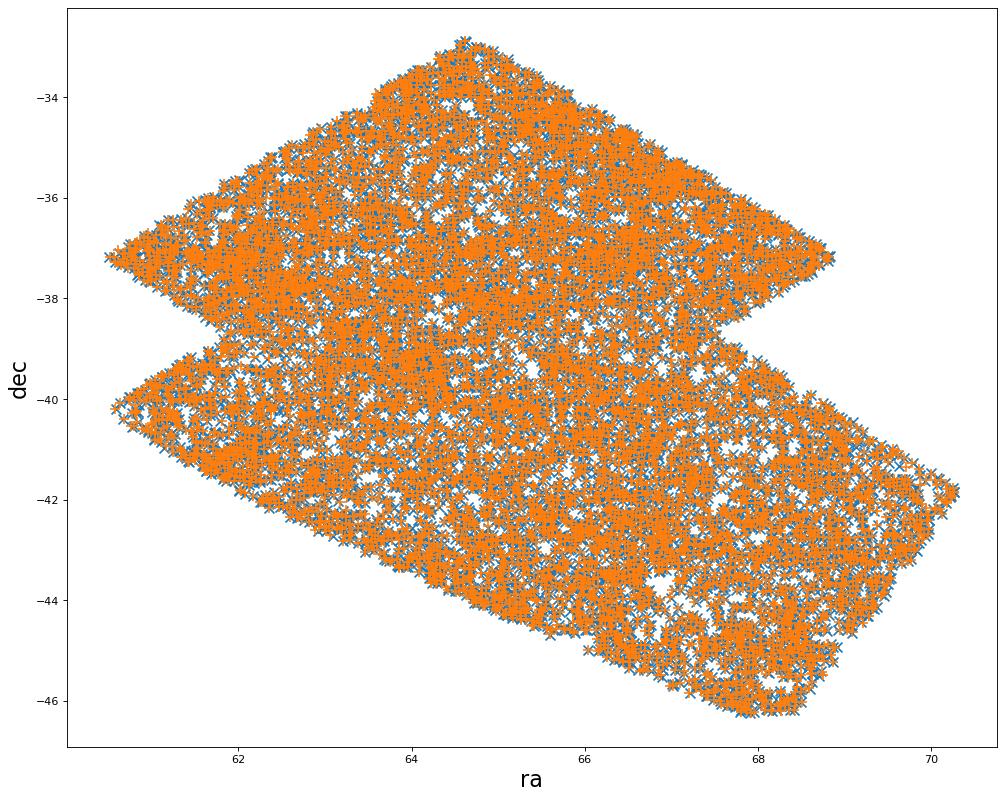

In [15]:
from matplotlib.pyplot import figure
figure(figsize=(15, 12), dpi=80)
plt.scatter(mt1['ra'], mt1['dec'], s=80, marker = 'x')
plt.scatter(mt2['ra'], mt2['dec'], s=80, marker = '+')
plt.xlabel('ra', fontsize = 20)
plt.ylabel('dec', fontsize = 20)

In [16]:
"""
%matplotlib widget 
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
# Creating plot
scatter = ax.scatter3D(mt1['ra'], mt1['z'], mt1['dec'], marker = 'x',s = 40)#c=mt1['z'], cmap='coolwarm')
scatter2 = ax.scatter3D(mt2['ra'], mt2['z'], mt2['dec'], marker = 'x',s=40)#c=mt2['z'], cmap='coolwarm')
#plt.colorbar(scatter)
#plt.colorbar(scatter2)
plt.title("simple 3D scatter plot")
plt.show()
"""

'\n%matplotlib widget \nfig = plt.figure(figsize = (10, 7))\nax = plt.axes(projection ="3d")\n# Creating plot\nscatter = ax.scatter3D(mt1[\'ra\'], mt1[\'z\'], mt1[\'dec\'], marker = \'x\',s = 40)#c=mt1[\'z\'], cmap=\'coolwarm\')\nscatter2 = ax.scatter3D(mt2[\'ra\'], mt2[\'z\'], mt2[\'dec\'], marker = \'x\',s=40)#c=mt2[\'z\'], cmap=\'coolwarm\')\n#plt.colorbar(scatter)\n#plt.colorbar(scatter2)\nplt.title("simple 3D scatter plot")\nplt.show()\n'

In [17]:
cdc1 = ClCatalog.read_full(outpath + 'cdc.fits')
cam1 = ClCatalog.read_full(outpath + 'cam.fits')

    * ClEvar used in matching: 0.13.8
    * ClEvar used in matching: 0.13.8


In [18]:
output_matched_catalog(outpath + 'cdc.fits', outpath + 'cam.fits',outpath+'output_catalog.fits', cdc1, cam1, matching_type='cross', overwrite=True)

In [20]:
c_merged = ClCatalog.read(outpath +'output_catalog.fits', 'merged',  tags = {'z_halo' : 'cat1_z', 'z_amico' : 'cat2_z', 'richness' : 'cat2_richness', 'mass' : 'cat1_mass', 'SN' : 'cat2_SN'})

/sps/lsst/users/namourou/conda_clone_210223/descv1.1/clevar/clevar/catalog.py:267: UserWarning: id column missing, additional one is being created.
  warnings.warn(


In [94]:
z_amico = c_merged['z_amico']
z_halo = c_merged['z_halo']
z_diff = (z_amico-z_halo)/(1+z_halo)

Text(0, 0.5, '(zamico-zhalo)(1+zhalo)')

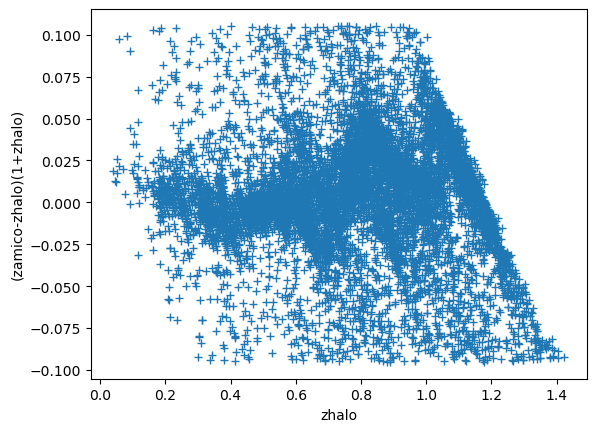

In [95]:
plt.errorbar(z_halo,(z_amico-z_halo)/(1+z_halo), marker = '+', linestyle = 'None')
plt.xlabel('zhalo')
plt.ylabel('(zamico-zhalo)(1+zhalo)')

In [96]:
z_c = z_diff[(z_diff>=.1) * (z_diff<=-.1)] # this is empty

In [97]:
z_c

<Column name='cat2_z' dtype='float64' length=0>

(array([ 347.,  352.,  483., 1084., 2999., 2247., 1343.,  545.,  261.,
         199.]),
 array([-0.09521282, -0.07516594, -0.05511906, -0.03507218, -0.01502531,
         0.00502157,  0.02506845,  0.04511533,  0.0651622 ,  0.08520908,
         0.10525596]),
 <BarContainer object of 10 artists>)

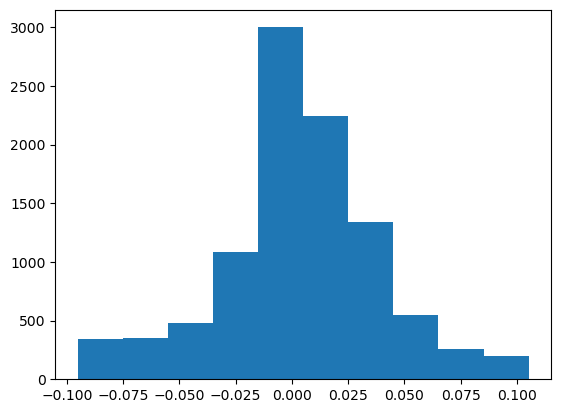

In [98]:
plt.hist(z_diff)

In [103]:
print(min(z_amico), min((z_halo-z_amico)/(1+z_halo)), max(z_amico), max((z_halo-z_amico)/(1+z_halo)))

0.059999999 -0.10525596023379123 1.1999999 0.09521281842416746


In [105]:
max(z_diff)# toutes les différences sont shiftées vers la droite? essayer de configurer bin à la main

0.10525596023379123

In [74]:
z_c

<Column name='cat2_z' dtype='float64' length=0>

Text(0, 0.5, 'mass')

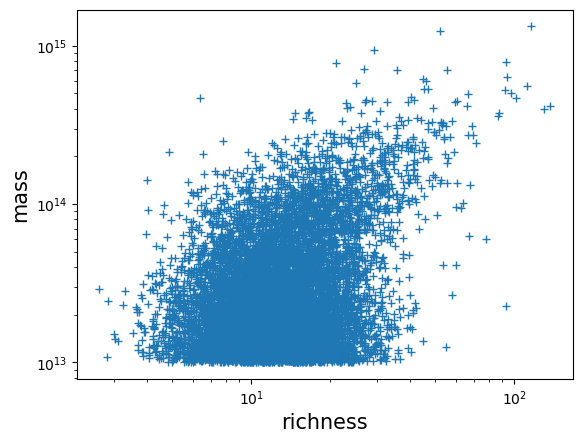

In [26]:
plt.loglog(c_merged['richness'], c_merged['mass'], marker = '+', linestyle = 'None')
plt.xlabel('richness', fontsize = 15)
plt.ylabel('mass', fontsize = 15)

In [35]:
#Setting condition
#plt.hist(c_merged['SN'], bins = 100)
c_merged_t = c_merged[c_merged['SN']>4]

In [36]:
print(len(c_merged), len(c_merged_t))

9860 2368


In [37]:
z_amico_t = c_merged_t['z_amico']
z_halo_t = c_merged_t['z_halo']

Text(0, 0.5, '(zamico-zhalo)(1+zhalo)')

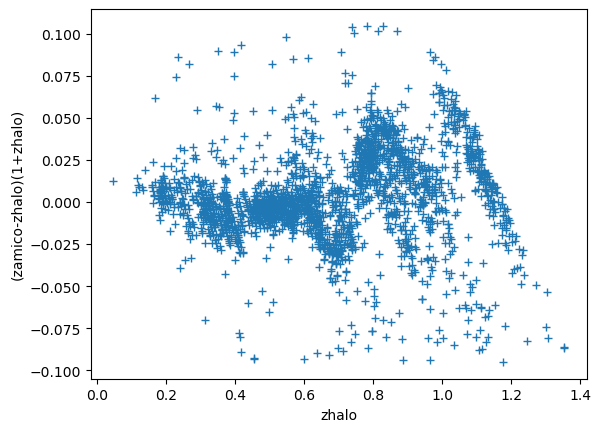

In [38]:
plt.errorbar(z_halo_t,(z_amico_t-z_halo_t)/(1+z_halo_t), marker = '+', linestyle = 'None')
plt.xlabel('zhalo')
plt.ylabel('(zamico-zhalo)(1+zhalo)')

Text(0, 0.5, 'mass')

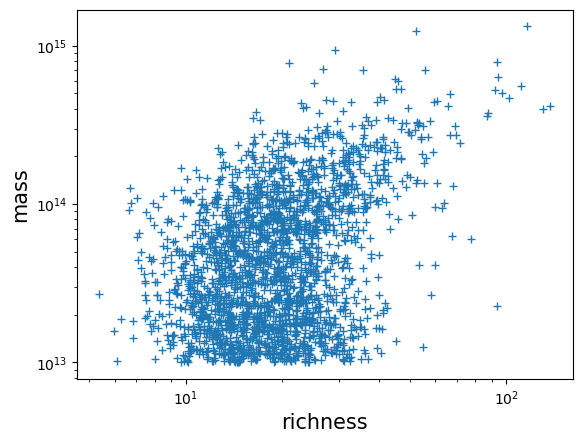

In [39]:
plt.loglog(c_merged_t['richness'], c_merged_t['mass'], marker = '+', linestyle = 'None')
plt.xlabel('richness', fontsize = 15)
plt.ylabel('mass', fontsize = 15)

In [46]:
max(cam['z'])

1.1999999

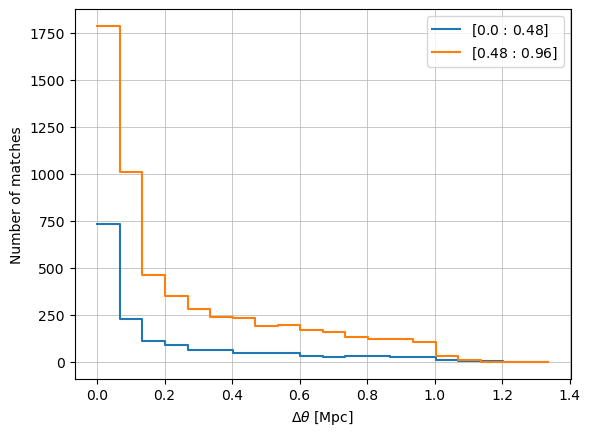

In [50]:
zbins = np.linspace(0, 1.2, 11)
from clevar.match_metrics.distances import ClCatalogFuncs as d_cf
info = d_cf.central_position(cdc1, cam1, 'cross', radial_bins=20, radial_bin_units='mpc',
                           col2='z', bins2=zbins[::4], cosmo = cosmo)

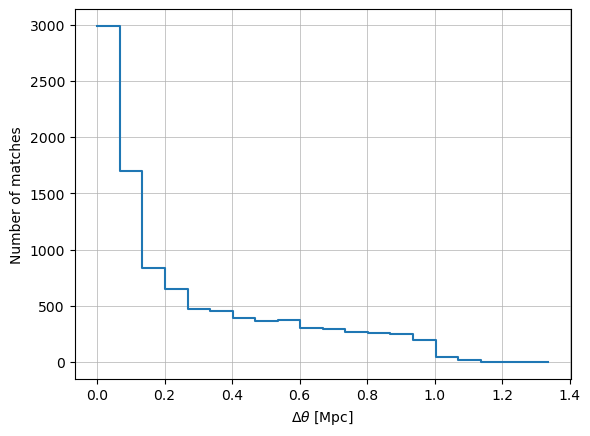

In [53]:
info = d_cf.central_position(cdc1, cam1, 'cross', radial_bins=20, radial_bin_units='mpc',
                           cosmo = cosmo)

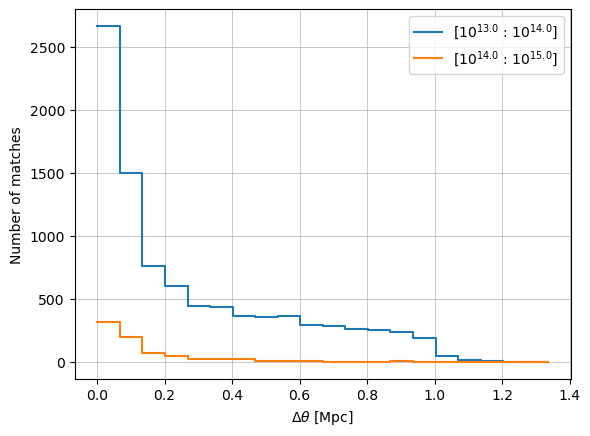

In [59]:
mbins = np.logspace(13, 15, 3)
info = distances.central_position(
    cdc1, cam1, 'cross', radial_bins=20, radial_bin_units='mpc',
    quantity_bins='mass', bins=mbins, log_quantity=True, cosmo = cosmo)

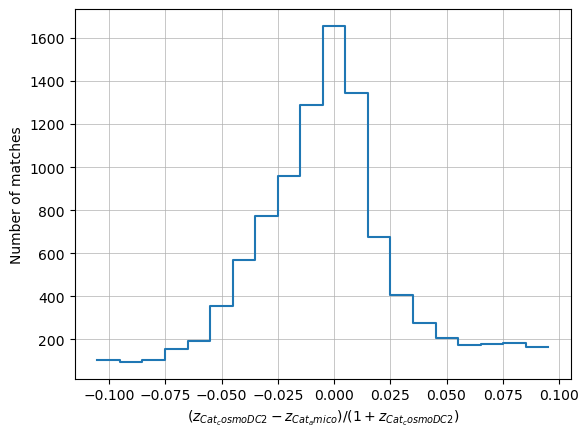

In [60]:
info = d_cf.redshift(cdc1, cam1, 'cross', redshift_bins=20, normalize='cat1')

In [61]:
print(info)
#first bin is -0.105 next to -0.095. Bin lenght is -0.11,-0.1

{'distances': <Column name='z' dtype='float64' length=9860>
 -0.008604638440850694
-0.0060283006768616565
-0.0002830610598617571
  -0.06159805326193618
 -0.005297551744272082
 -0.004345521010180951
 -0.026839160665384713
 -0.010467708051106603
 -0.059898581438321524
  0.007602438387789756
 0.0030785088222260756
  -0.02047907933295582
                   ...
   0.03451516241490587
   0.03932546155609478
   0.03033067560259091
   0.03800783472515117
   0.03573548583252369
   0.08439479815238995
   0.05776653296681209
   0.09351552431856061
   0.08318933399475884
   0.07428755623650729
   0.08850595435989382
   0.07684763988546109, 'data': {'hist': array([ 104,   95,  105,  156,  190,  355,  570,  773,  957, 1290, 1656,
       1343,  677,  407,  275,  208,  173,  179,  184,  163]), 'distance_bins': array([-0.10525596, -0.09523252, -0.08520908, -0.07518564, -0.0651622 ,
       -0.05513877, -0.04511533, -0.03509189, -0.02506845, -0.01504501,
       -0.00502157,  0.00500187,  0.01502531,  0.0

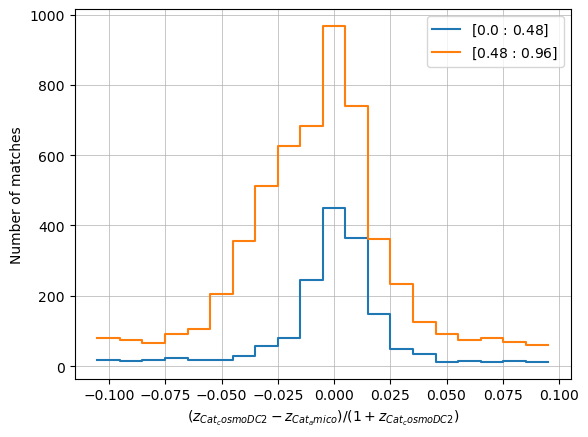

In [48]:
info = d_cf.redshift(cdc1, cam1, 'cross', redshift_bins=20,
                   col2='z', bins2=zbins[::4], normalize='cat1')

Text(0, 0.5, 'Completeness')

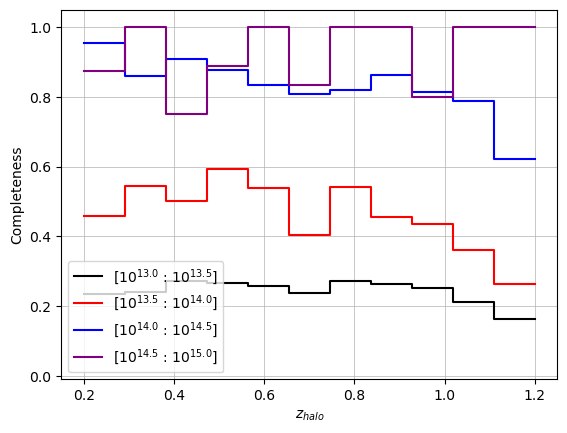

In [126]:
from clevar.match_metrics.recovery import ClCatalogFuncs as r_cf
#zbins = np.linspace(0.2,1.5,14)
zbins = np.linspace(0.2,1.2,12)
mbins = [10**13,10**13.5,10**14,10**14.5,10**15]
#zbins = np.linspace(0, 1.6, 9)
#mbins = np.logspace(14, 15, 5)
fig = plt.figure()#figsize=(figx,figy))
info = r_cf.plot(cdc1, col1='z', col2='mass', bins1=zbins, bins2=mbins, matching_type='cross', legend_format=lambda x: f'10^{{{np.log10(x)}}}', lines_kwargs_list = [{'color':'black'}, {'color':'red'}, {'color':'blue'}, {'color':'purple'}])
info['ax'].set_xlabel('$z_{halo}$')
info['ax'].set_ylabel('Completeness') 
#info['ax'].set_ylim(0,1.2)
#info['ax'].set_xlim(0.2,1.6) 
#info['ax'].set_title(matching)
#plt.savefig(outpath+'recovery_plot.png', bbox_inches='tight')
#plt.close(fig)


(0.2, 1.2)

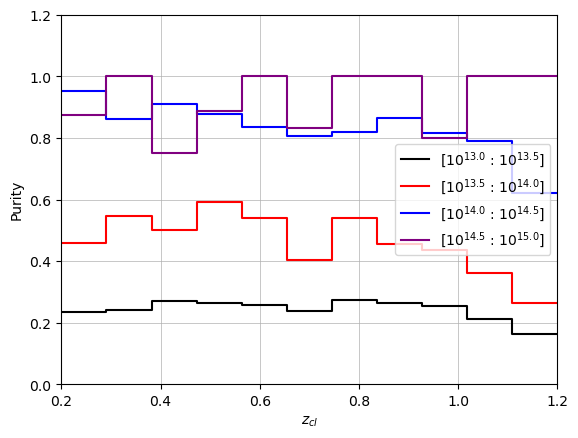

In [128]:
zbins = np.linspace(0.2, 1.2, 12)
mbins = np.logspace(13, 15, 5)
fig = plt.figure()
info = r_cf.plot(cdc1, col1='z', col2='mass', bins1=zbins, bins2=mbins, matching_type='cross', legend_format=lambda x: f'10^{{{np.log10(x)}}}',lines_kwargs_list = [{'color':'black'}, {'color':'red'}, {'color':'blue'}, {'color':'purple'}])
info['ax'].set_xlabel('$z_{cl}$')
info['ax'].set_ylabel('Purity') 
info['ax'].set_ylim(0,1.2)
info['ax'].set_xlim(0.2,1.2) 

In [129]:
print(info)

{'data': {'recovery': array([[0.2338594 , 0.45731707, 0.95348837, 0.875     ],
       [0.23990107, 0.54573171, 0.86046512, 1.        ],
       [0.27057079, 0.5       , 0.90909091, 0.75      ],
       [0.26510235, 0.5923913 , 0.87777778, 0.88888889],
       [0.25873544, 0.5389948 , 0.83486239, 1.        ],
       [0.2380198 , 0.40409683, 0.80722892, 0.83333333],
       [0.27230339, 0.54160363, 0.82      , 1.        ],
       [0.26347305, 0.45454545, 0.86363636, 1.        ],
       [0.25298737, 0.43560606, 0.81538462, 0.8       ],
       [0.21264182, 0.36206897, 0.78846154, 1.        ],
       [0.16222084, 0.26386555, 0.62222222, 1.        ]]), 'edges1': array([0.2       , 0.29090909, 0.38181818, 0.47272727, 0.56363636,
       0.65454545, 0.74545455, 0.83636364, 0.92727273, 1.01818182,
       1.10909091, 1.2       ]), 'edges2': array([1.00000000e+13, 3.16227766e+13, 1.00000000e+14, 3.16227766e+14,
       1.00000000e+15]), 'matched': array([[163,  75,  41,   7],
       [291, 179,  74,   7

Text(0, 0.5, 'Purity')

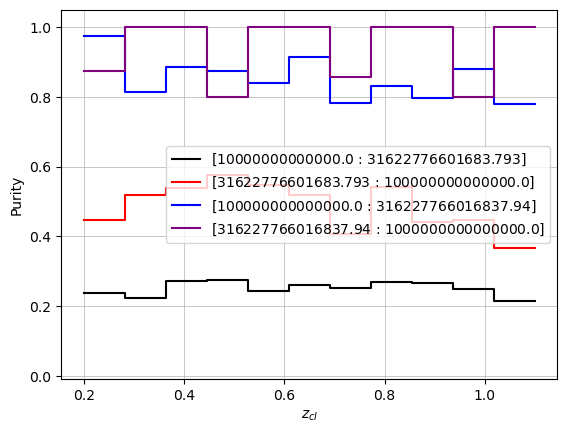

In [117]:
zbins = np.linspace(0.2,1.1,12)
mbins = [10**13,10**13.5,10**14,10**14.5,10**15]
#zbins = np.linspace(0, 1.6, 9)
#mbins = np.logspace(14, 15, 5)
fig = plt.figure()
info = r_cf.plot(cdc1, col1='z', col2='mass', bins1=zbins, bins2=mbins, matching_type='cross', lines_kwargs_list = [{'color':'black'}, {'color':'red'}, {'color':'blue'}, {'color':'purple'}])
info['ax'].set_xlabel('$z_{cl}$')
info['ax'].set_ylabel('Purity') 
#info['ax'].set_ylim(0.5,1.2)
#info['ax'].set_xlim(0.2,1.6) 
#info['ax'].set_title(matching)

(0.2, 1.6)

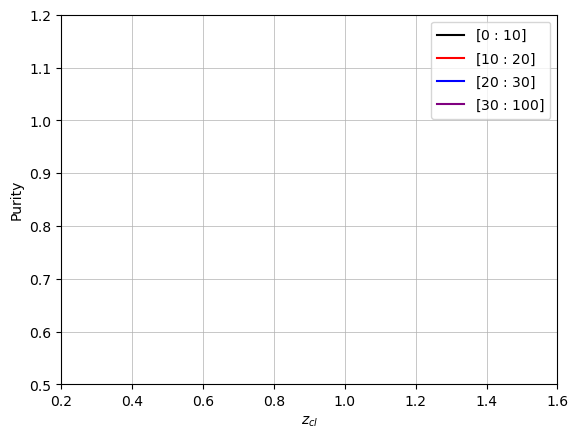

In [132]:
zbins = np.linspace(0.2,1.1,10)
mbins = [0,10,20,30,100]
#zbins = np.linspace(0, 1.6, 9)
#mbins = np.logspace(14, 15, 5)
fig = plt.figure()
info = r_cf.plot(cdc1, col1='z', col2='mass', bins1=zbins, bins2=mbins, matching_type='cross', lines_kwargs_list = [{'color':'black'}, {'color':'red'}, {'color':'blue'}, {'color':'purple'}])
info['ax'].set_xlabel('$z_{cl}$')
info['ax'].set_ylabel('Purity') 
info['ax'].set_ylim(0.5,1.2)
info['ax'].set_xlim(0.2,1.6) 

In [ ]:
#Trying to plot completness naive way
comp = len(mt1)/len(cdc)
print(comp)

In [ ]:
#plotting completness in redshift bins
print(max(mt1['z']))
print(max(cdc['z']))

In [ ]:
z_bins = np.linspace(0,max(mt1['z']),10)

In [ ]:
comp_l = []
z_l = []
for i in range(1, len(z_bins)):
    cdc1 = cdc[(cdc['z']<z_bins[i-1]) * (cdc['z']<z_bins[i-1])]
    mt11 = mt1[(mt1['z']<z_bins[i-1]) * (mt1['z']<z_bins[i-1])]
    if len(cdc1) != 0:
        comp_l.append(len(mt11)/len(cdc1))
    else : 
        comp_l.append(1)
    z_l.append((z_bins[i-1]+z_bins[i])/2)

In [ ]:
print(z_l, comp_l)

In [ ]:
fig = plt.figure(figsize = (10, 7))
plt.errorbar(z_l, comp_l, marker = '+', linestyle = 'None')
plt.xlabel('completude')
plt.ylabel('redshift')

In [ ]:
len(cdc[cdc['z']<1.5])